# **Предсказание наличия сердечно-сосудистых заболеваний**

1. Необходимо предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Обучить несколько разных моделей на наборе данных сердечно-сосудистых заболеваний: логистическую регрессию, бустинг, лес и т. д. - на ваш выбор 2-3 варианта.
2. Вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики).
3. Вывести сравнение полученных моделей по метрикам бизнеса:
    - стоимость лечения 15000р, если сделали тест и начали лечить вовремя;
    - стоимость лечения 20000р, если упустили и начали лечить, когда уже проявились все симптомы;
    - стоимость теста 1400р.
4. Сделать выводы о том, какая модель справилась с задачей лучше других.
5. *Найти порог классификации для лучшей модели по метрикам бизнеса.



# Подготовка данных

Импортируем необходимые библиотеки и загрузим данные.

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.7 MB/s eta 0:00:00


In [ ]:
!pip install catboost

In [ ]:
import catboost as catb
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import  RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (f1_score, roc_auc_score, roc_curve, precision_score, classification_report, precision_recall_curve, confusion_matrix)
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
!wget 'https://drive.google.com/uc?export=download&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G' -O train_case2.csv

--2023-11-17 09:18:50--  https://drive.google.com/uc?export=download&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G
Resolving drive.google.com (drive.google.com)... 142.251.171.138, 142.251.171.113, 142.251.171.100, ...
Connecting to drive.google.com (drive.google.com)|142.251.171.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/n3hui6d6upfpkadu9vhiii7500i46n84/1700212725000/14904333240138417226/*/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G?e=download&uuid=9ac59dea-cb95-4313-a132-3acc2eea6327 [following]
--2023-11-17 09:18:50--  https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/n3hui6d6upfpkadu9vhiii7500i46n84/1700212725000/14904333240138417226/*/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G?e=download&uuid=9ac59dea-cb95-4313-a132-3acc2eea6327
Resolving doc-00-c0-docs.googleusercontent.com (doc-00-c0-docs.googleusercontent.com)... 173.194.194.132, 


Создадим функции для визуализации матрицы ошибок и расчета порога классификации.



In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def business_threshold_calibrate(y_test, y_score, thresholds, rubl_test=1400, rubl_early_treatment=15000, rubl_late_treatment=20000):
    business_threshold = 0
    r_test_all_r_ML_ = 0

    rubl_ML_ = 1_000_000_000

    rs = []
    n = 20
    for opt_buisness_tr in np.linspace(0, 1, n).tolist():

        cnf_matrix = confusion_matrix(y_test, y_score > (opt_buisness_tr))
        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        rubl_ML = (TP + FP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment

        if rubl_ML < rubl_ML_:
            business_threshold = opt_buisness_tr

            rubl_ML_ = rubl_ML

        rs.append(rubl_ML)

    print('Расходы, если использовать МЛ: ', rubl_ML_)

    plt.title('Потери при МЛ решении')
    plt.xlabel('Отсечка')
    plt.ylabel('Потери')
    plt.plot(np.linspace(0,1,n), rs)
    plt.show()
    return business_threshold

Загрузим датасет.

In [ ]:
df = pd.read_csv('train_case2.csv', sep=';')
df.head(10)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1
8,13,17668,1,158,71.0,110,70,1,1,0,0,1,0
9,14,19834,1,164,68.0,110,60,1,1,0,0,0,0


Датасет содержит 100.000 реальных клинических анализов. В нём используются признаки, которые можно разбить на 3 группы:

- Объективные признаки: возраст, вес, рост, пол.

- Результаты измерения: артериальное давление верхнее и нижнее, холестерин, глюкоза.

- Субъективные признаки: курение, употребление алкоголя, физическая активность.

Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.


Датасет содержит 12 признаков:

- Id – идентификатор,

- age  - возраст в днях,

- gender - пол,

- height – рост,

- weight – вес,

- ap_hi – систолическое артериальное давление,

- ap_lo – диастолическое артериальное давление,

- cholesterol – холестерин,

- gluc – глюкоза,

- smoke – курение,

- alco – употребление алкоголя,

-  active – активность.

Целевой признак: cardio - наличие или отсутствие сердечно-сосудистых заболеваний.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


Пропусков нет. Все признаки имеют числовой тип. Но, вероятно, на самом деле пол и субъективные  признаки являются категориальными, а показатели холестерина и глюкозы имеют порядок. Попробуем вывести количество значений некоторых признаков, чтобы убедится, что они не являются числовыми.

In [ ]:
df['smoke'].value_counts()

,count
smoke,
0,63831
1,6169


In [ ]:
df['cholesterol'].value_counts()

,count
cholesterol,
1,52385
2,9549
3,8066


In [ ]:
df['alco'].value_counts()

,count
alco,
0,66236
1,3764


In [ ]:
df['active'].value_counts()

,count
active,
1,56261
0,13739


In [ ]:
continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'smoke', 'alco', 'active']
ordinal_cols = ['gluc', 'cholesterol']

Удалим столбец ‘id’, так как он не несет полезной информации.

In [ ]:
df.drop(labels='id', axis=1, inplace=True)

Стандартизируем числовые столбцы для стабилизации обучения. Выполним дамми-кодирование для признака 'gender'. Субъективные признаки являются бинарными, поэтому не будем их преобразовывать. Порядковые признаки тоже не будем трансформировать, так как их порядок может нести важную информацию для обучения.

In [ ]:
scaler = StandardScaler()
scaler.fit(df[continuos_cols])
df[continuos_cols] = scaler.transform(df[continuos_cols])
df = pd.get_dummies(df, drop_first=True, columns = ['gender'])
df.head(3)

,age,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,gender_2
0,-0.436062,0.443452,-0.847873,-0.122182,-0.088238,1,1,0,0,1,0,True
1,0.307686,-1.018168,0.749831,0.072610,-0.035180,3,1,0,0,1,1,False
2,-0.247997,0.078047,-0.708942,0.007679,-0.141297,3,1,0,0,0,1,False


Перезапишем cat_cols.

In [ ]:
cat_cols = ['gender_2', 'smoke',	'alco',	'active']

Проверим, на сколько классы сбалансированы.

In [ ]:
df['cardio'].value_counts()

,count
cardio,
0,35021
1,34979


Дисбаланса не наблюдаем.

Разделим данные на train и test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='cardio'), df['cardio'], random_state=42)

Создадим переменные, при помощи которых будем отслеживать бизнес-метрики:
- стоимость теста: rubl_test,
- стоимость лечения, если сделали тест и начали лечить вовремя: rubl_early_treatment,
- стоимость лечения, если правильный момент лечения был упущен, и лечение началось, когда уже проявились все симптомы: rubl_late_treatment.


In [ ]:
RUBL_TEST = 1400
RUBL_EARLY_TREATMENT = 15000
RUBL_LATE_TREATMENT = 20000

# Обучение моделей

## LogisticRegression

Обучим базовую модель логистической регрессии.

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [ ]:
preds_logreg = logreg.predict_proba(X_test)[:, 1]
preds_logreg[:20]

array([0.74514309, 0.82084011, 0.69804332, 0.49994424, 0.3369718 ,
       0.42473858, 0.2403836 , 0.47863811, 0.93452618, 0.78074815,
       0.48119187, 0.40035464, 0.13153745, 0.45619522, 0.70777162,
       0.9164303 , 0.61192499, 0.0887141 , 0.17440618, 0.39436619])

In [ ]:
precision_logreg, recall_logreg, thresholds_logreg = precision_recall_curve(y_test, preds_logreg)
fscore_logreg = (2 * precision_logreg * recall_logreg) / (precision_logreg + recall_logreg)
ix = np.argmax(fscore_logreg)
print(f'Best Threshold={thresholds_logreg[ix]}, F-Score={fscore_logreg[ix]:.3f}, Precision={precision_logreg[ix]:.3f}, Recall={recall_logreg[ix]:.3f}')

Best Threshold=0.391985595557597, F-Score=0.735, Precision=0.650, Recall=0.844


In [ ]:
roc_auc_logreg = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])
print(f"roc auc score: {roc_auc_score(y_train, logreg.predict_proba(X_train)[:, 1])}")
print(f"roc auc score: {roc_auc_logreg}")

roc auc score: 0.7820916373032771
roc auc score: 0.7848018387365631


На тренировочных и тестовых данных значения roc_auc близкие - переобучения нет.

Метрики показывают приемлемое качество, но необходимо пробовать улучшить модель.

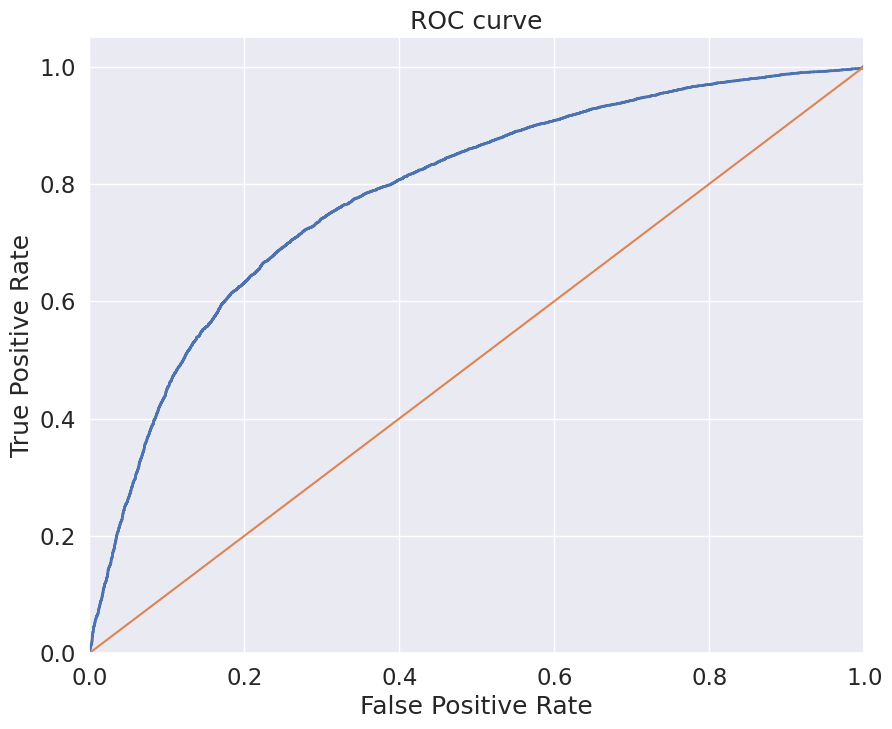

In [ ]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, preds_logreg, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

ROC curve расположена выше случайной кривой – это неплохой результат, но будем  пробовать улучшить показатель.

Выведем матрицу ошибок.

Confusion matrix, without normalization
[[4688 4000]
 [1374 7438]]


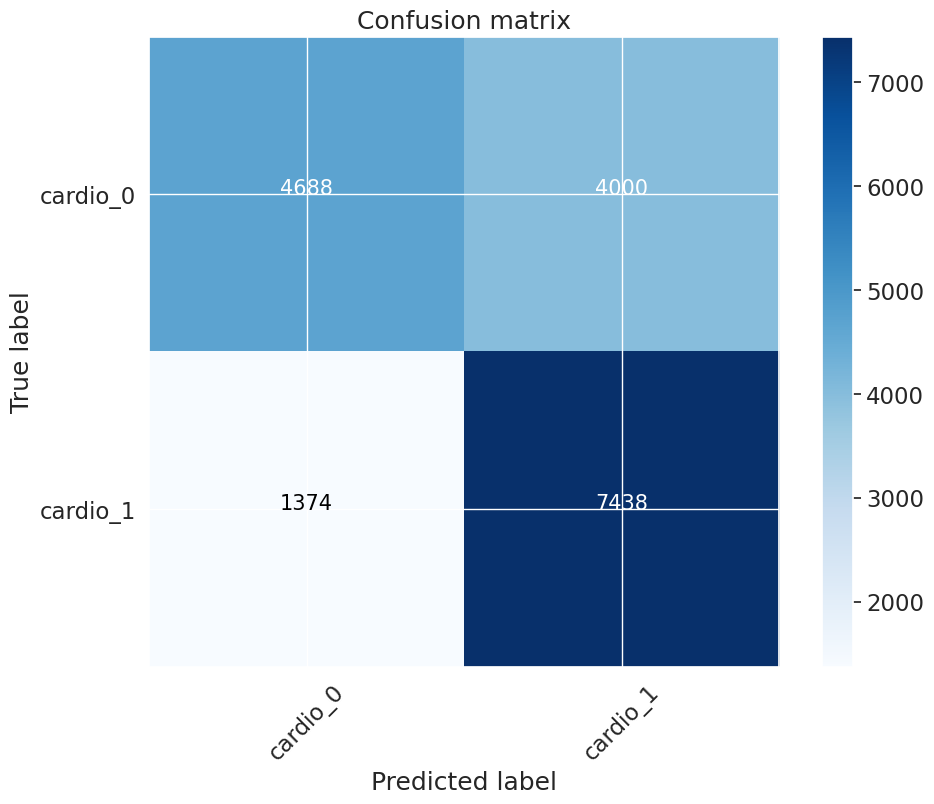

In [ ]:
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix_logreg = confusion_matrix(y_test, preds_logreg > thresholds_logreg[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_logreg, classes=['cardio_0', 'cardio_1'], title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Модель правильно предсказала 4688 случаев отсутствия заболевания и 7438 случаев его наличия. Модель ошибочно предсказала отсутствие заболевания у 1374 человек, и наличие заболевания при его отсутствии у 4000 человек.

In [ ]:
TN_l = cnf_matrix_logreg[0][0]
FN_l = cnf_matrix_logreg[1][0]
TP_l = cnf_matrix_logreg[1][1]
FP_l = cnf_matrix_logreg[0][1]

TPR_l = TP_l / (TP_l+FN_l)
FPR_l = FP_l / (FP_l+TN_l)
TNR_l = TN_l / (FP_l+TN_l)
TPR_l, FPR_l, TNR_l

(np.float64(0.8440762596459374),
 np.float64(0.4604051565377532),
 np.float64(0.5395948434622467))

Модель находит 84% людей с сердечно-сосудистыми заболеваниями (TPR), в 46% случаев модель распознает здоровых людей как людей с ССЗ (FPR ), 54% людей с ССЗ правильно распознаны (TNR) моделью.

In [ ]:
rubl_1_logreg = (FN_l + TP_l) * RUBL_LATE_TREATMENT
print('Расходы, если не делать тест и ждать симптомов:', rubl_1_logreg)

rubl_test_all_logreg = np.sum(cnf_matrix_logreg) * RUBL_TEST + (FN_l + TP_l) * RUBL_EARLY_TREATMENT
print('Расходы, если делать тест всем и лечить группу больных:', rubl_test_all_logreg)

rubl_logreg = (FP_l + TP_l) * RUBL_TEST + FN_l * RUBL_LATE_TREATMENT + TP_l * RUBL_EARLY_TREATMENT
print('Расходы при использовании логистической регрессии:', rubl_logreg)

Расходы, если не делать тест и ждать симптомов: 176240000
Расходы, если делать тест всем и лечить группу больных: 156680000
Расходы при использовании логистической регрессии: 155063200


In [ ]:
expensesl1 = rubl_1_logreg - rubl_logreg
expensesl2 = rubl_1_logreg - rubl_test_all_logreg
expensesl3 = rubl_test_all_logreg - rubl_logreg
print(f'Расходы "решение не делать тесты - расходы с МL": {expensesl1}')
print(f'Расходы "решение не делать тесты - расходы сделать тесты всем": {expensesl2}')
print(f'Расходы "сделать тесты всем - решение делать тесты ML": {expensesl3 }')

Расходы "решение не делать тесты - расходы с МL": 21176800
Расходы "решение не делать тесты - расходы сделать тесты всем": 19560000
Расходы "сделать тесты всем - решение делать тесты ML": 1616800


## CatBoostClassifier

Обучим базовую модель CatBoost.

In [ ]:
cb = catb.CatBoostClassifier(silent=True, cat_features=cat_cols+ordinal_cols)
cb.fit(X_train, y_train)

In [ ]:
preds_cb = cb.predict_proba(X_test)[:, 1]
preds_cb

array([0.83833679, 0.8528086 , 0.66903293, ..., 0.2849199 , 0.35799791,
       0.66932168])

Попробуем подобрать некоторые параметры модели и применим кросс-валидацию  для улучшения качества обучения.

In [ ]:
params_cb = {'n_estimators':[50, 100, 200, 500],
             'max_depth':[3, 5, 7, 10],
             'learning_rate':[0.001, 0.01, 0.05, 0.1]}

In [ ]:
cv=KFold(n_splits=3, random_state=42, shuffle=True)

In [ ]:
%%time

cb = RandomizedSearchCV(cb, params_cb, scoring='f1', cv=cv, n_jobs=-1)
cb.fit(X_train, y_train)

CPU times: user 22.7 s, sys: 1.38 s, total: 24.1 s
Wall time: 4min 25s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7bd91f829f40>,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [50, 100, 200, 500]},
                   scoring='f1')

Выведем наилучшие параметры.

In [ ]:
cb.best_params_

{'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1}

In [ ]:
final_cb = catb.CatBoostClassifier(n_estimators=200, max_depth=7, learning_rate=0.1,
                                      silent=True, random_state=21)
final_cb.fit(X_train, y_train)

In [ ]:
preds_cb = cb.predict_proba(X_test)[:, 1]
preds_cb

array([0.82351044, 0.85560611, 0.66979074, ..., 0.28015623, 0.38276627,
       0.63008552])

In [ ]:
precision_cb, recall_cb, thresholds_cb = precision_recall_curve(y_test, preds_cb)
fscore_cb = (2 * precision_cb * recall_cb) / (precision_cb + recall_cb)
ix = np.argmax(fscore_cb)
print(f'Best Threshold={thresholds_cb[ix]}, F-Score={fscore_cb[ix]:.3f}, Precision={precision_cb[ix]:.3f}, Recall={recall_cb[ix]:.3f}')

Best Threshold=0.4009838830475097, F-Score=0.747, Precision=0.708, Recall=0.791


In [ ]:
roc_auc_cb = roc_auc_score(y_test, cb.predict_proba(X_test)[:, 1])
print(f"roc auc score: {roc_auc_score(y_train, cb.predict_proba(X_train)[:, 1])}")
print(f"roc auc score: {roc_auc_cb}")

roc auc score: 0.818261035102434
roc auc score: 0.8039151640802054


Метрики немного улучшились.

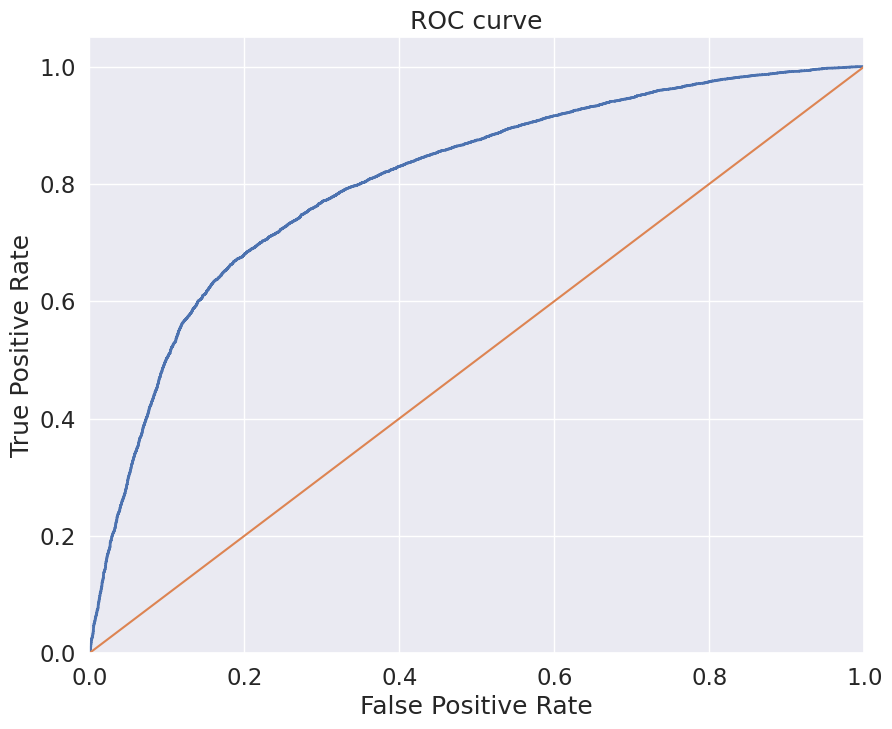

In [ ]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, preds_cb, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

ROC curve проходит левее и выше предыдущей кривой, значит, модель эффективнее различает положительные и отрицательные примеры.

Confusion matrix, without normalization
[[5814 2874]
 [1839 6973]]


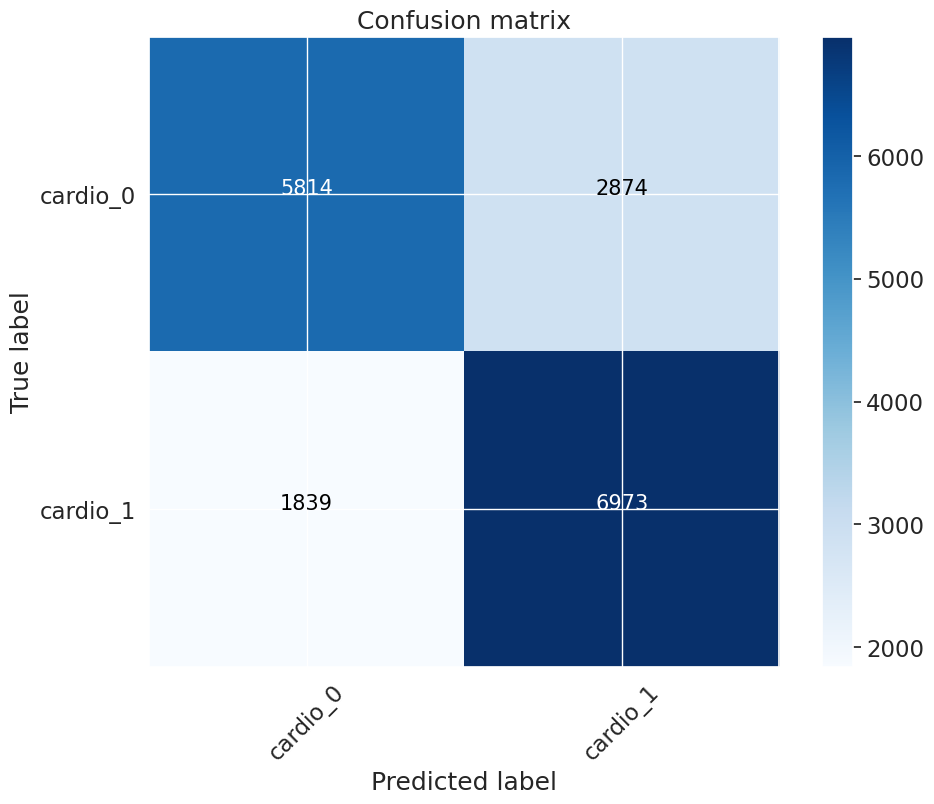

In [ ]:
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix_cb = confusion_matrix(y_test, preds_cb > thresholds_cb[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_cb, classes=['cardio_0', 'cardio_1'], title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Модель правильно предсказала 5814 случаев отсутствия заболевания и 6973 случаев его наличия. Модель ошибочно предсказала отсутствие заболевания у 1839 человек, и наличие заболевания при его отсутствии у 2874 человек. По сравнению с предыдущей моделью, CatBoost лучше находит действительно здоровых, но чуть хуже на самом деле больных. Снизилось количество ложно отрицательных и ложно положительных срабатываний.

In [ ]:
TN_c = cnf_matrix_cb[0][0]
FN_c = cnf_matrix_cb[1][0]
TP_c = cnf_matrix_cb[1][1]
FP_c = cnf_matrix_cb[0][1]

TPR_c = TP_c / (TP_c+FN_c)
FPR_c = FP_c / (FP_c+TN_c)
TNR_c = TN_c / (FP_c+TN_c)
TPR_c, FPR_c, TNR_c

(np.float64(0.791307308216069),
 np.float64(0.3308011049723757),
 np.float64(0.6691988950276243))

Модель находит 79% людей с сердечно-сосудистыми заболеваниями (TPR),  в 33% случаев модель распознает здоровых людей как людей с ССЗ (FPR ), 67% людей с ССЗ правильно распознаны (TNR).

In [ ]:
rubl_1_cb = (FN_c + TP_c) * RUBL_LATE_TREATMENT
print('Расходы, если не делать тест и ждать симптомов:', rubl_1_cb)

rubl_test_all_cb = np.sum(cnf_matrix_cb) * RUBL_TEST + (FN_c + TP_c) * RUBL_EARLY_TREATMENT
print('Расходы, если делать тест всем и лечить группу больных:', rubl_test_all_cb)

rubl_cb = (FP_c + TP_c) * RUBL_TEST + FN_c * RUBL_LATE_TREATMENT + TP_c * RUBL_EARLY_TREATMENT
print('Расходы при использовании CatBoost:', rubl_cb)

Расходы, если не делать тест и ждать симптомов: 176240000
Расходы, если делать тест всем и лечить группу больных: 156680000
Расходы при использовании CatBoost: 155160800


In [ ]:
expensesc1 = rubl_1_cb - rubl_cb
expensesc2 = rubl_1_cb - rubl_test_all_cb
expensesc3 = rubl_test_all_cb - rubl_cb
print(f'Расходы "решение не делать тесты - расходы с МL": {expensesc1}')
print(f'Расходы "решение не делать тесты - расходы сделать тесты всем": {expensesc2}')
print(f'Расходы "сделать тесты всем - решение делать тесты ML": {expensesc3 }')

Расходы "решение не делать тесты - расходы с МL": 21079200
Расходы "решение не делать тесты - расходы сделать тесты всем": 19560000
Расходы "сделать тесты всем - решение делать тесты ML": 1519200


Расходы при использовании CatBoost стали немного меньше, чем расходы при использовании предыдущей модели. Однако расходы на решение не делать тесты и сделать тесты всем с применением ML выросли.

## RandomForestClassifier

Обучим базовую модель случайного леса.

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

In [ ]:
preds_rf = rf.predict_proba(X_test)[:, 1]
preds_rf

array([0.85, 0.76, 0.6 , ..., 0.09, 0.18, 0.62])

In [ ]:
param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}

In [ ]:
grid_search = GridSearchCV(rf, param_grid=param_grid)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 6, 9], 'max_leaf_nodes': [3, 6, 9],
                         'n_estimators': [25, 50, 100, 150]})

In [ ]:
grid_search.best_params_

{'max_depth': 6, 'max_leaf_nodes': 9, 'n_estimators': 25}

In [ ]:
rf = RandomForestClassifier(max_depth=6,
                            max_leaf_nodes=9,
                            n_estimators=25)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, max_leaf_nodes=9, n_estimators=25)

In [ ]:
preds_rf = rf.predict_proba(X_test)[:, 1]
preds_rf

array([0.70730837, 0.7696945 , 0.63594223, ..., 0.28458864, 0.35482221,
       0.69272694])

In [ ]:
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, preds_rf)
fscore_rf = (2 * precision_rf * recall_rf) / (precision_rf + recall_rf)
ix = np.argmax(fscore_rf)
print(f'Best Threshold={thresholds_rf[ix]}, F-Score={fscore_rf[ix]:.3f}, Precision={precision_rf[ix]:.3f}, Recall={recall_rf[ix]:.3f}')

Best Threshold=0.3819189658653472, F-Score=0.738, Precision=0.662, Recall=0.833


In [ ]:
roc_auc_rf = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
print(f"roc auc score_train: {roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1])}")
print(f"roc auc score_test: {roc_auc_rf}")

roc auc score_train: 0.791816184049621
roc auc score_test: 0.7912279768861146


Метрики получились чуть лучше LogisticRegression, но чуть хуже CatBoostClassifier.

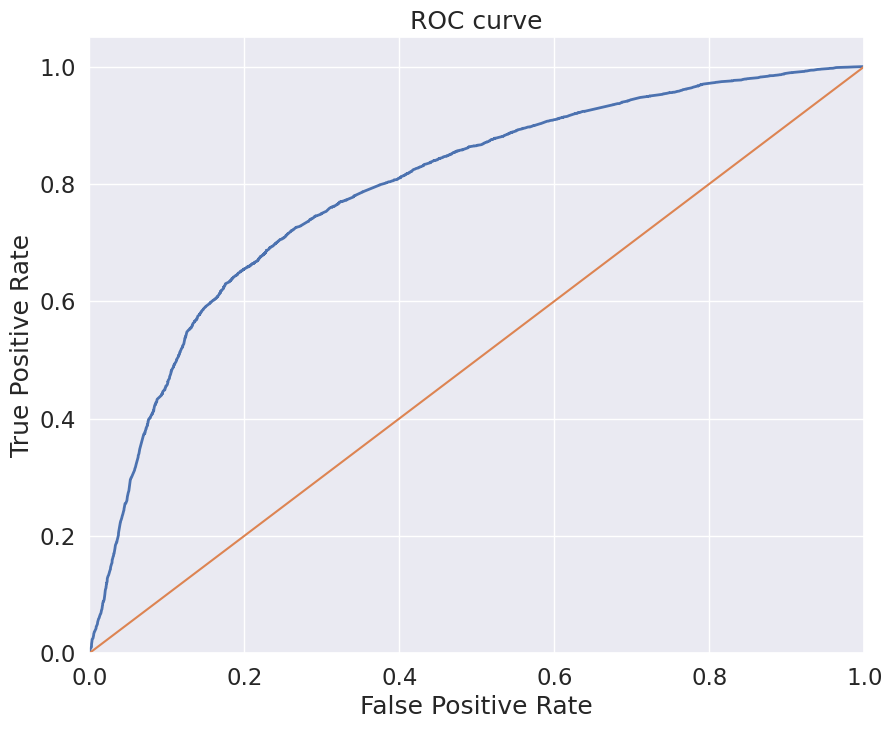

In [ ]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, preds_rf, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

ROC curve расположена выше случайной кривой – хороший результат.

Выведем матрицу ошибок.


Confusion matrix, without normalization
[[4934 3754]
 [1471 7341]]


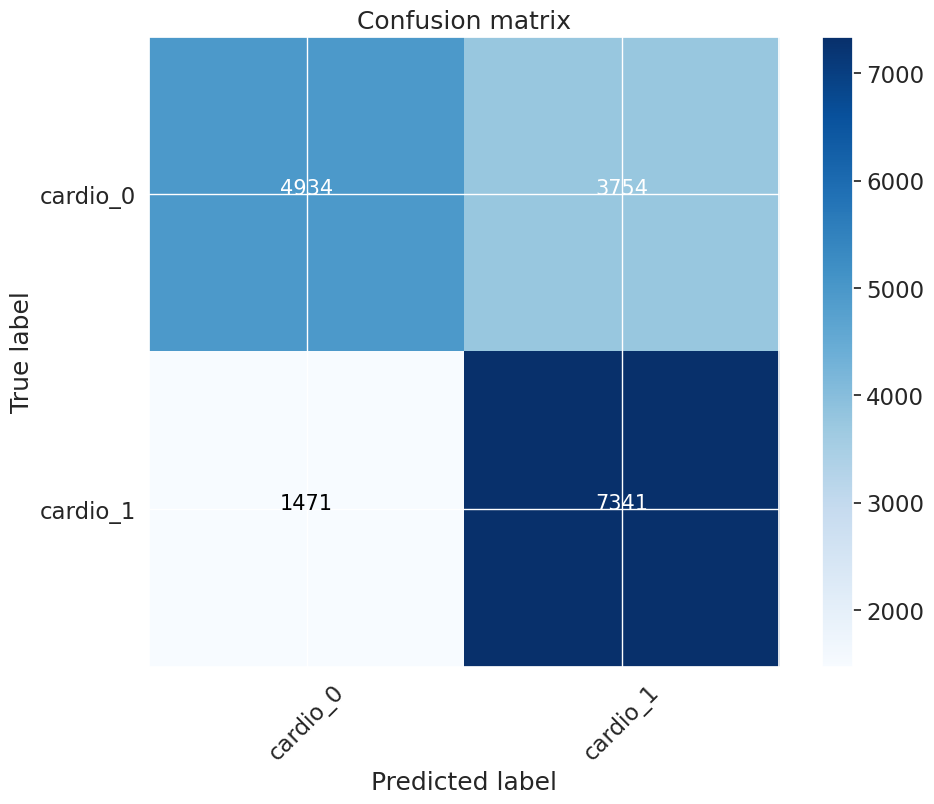

In [ ]:
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix_rf = confusion_matrix(y_test, preds_rf > thresholds_rf[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_rf, classes=['cardio_0', 'cardio_1'], title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Модель правильно предсказала 4934 случаев отсутствия заболевания и 7341 случаев его наличия. Модель ошибочно предсказала отсутствие заболевания у 1471 человек, и наличие заболевания при его отсутствии у 3754 человек. Получается, что модель предсказывает действительно здоровых и действительно больных лучше, чем LogisticRegression, но хуже, чем CatBoostClassifier. Количество ложно отрицательных и ложно положительных срабатываний также находится между качеством LogisticRegression и CatBoostClassifier.

In [ ]:
TN_f = cnf_matrix_rf[0][0]
FN_f = cnf_matrix_rf[1][0]
TP_f = cnf_matrix_rf[1][1]
FP_f = cnf_matrix_rf[0][1]

TPR_f = TP_f / (TP_f+FN_f)
FPR_f = FP_f / (FP_f+TN_f)
TNR_f = TN_f / (FP_f+TN_f)
TPR_f, FPR_f, TNR_f

(np.float64(0.8330685428960508),
 np.float64(0.4320902394106814),
 np.float64(0.5679097605893186))

Модель находит 83% людей с сердечно-сосудистыми заболеваниями (TPR), в 43% случаев модель распознает здоровых людей как людей с ССЗ (FPR), 57% людей с ССЗ правильно распознаны (TNR).

Качество сопоставимо с Catboost. По сравнению  с логистической регрессией модель совершает меньше FPR ошибок.


In [ ]:
rubl_1_rf = (FN_f + TP_f) * RUBL_LATE_TREATMENT
print('Расходы, если не делать тест и ждать симптомов:', rubl_1_rf)

rubl_test_all_rf = np.sum(cnf_matrix_rf) * RUBL_TEST + (FN_f + TP_f) * RUBL_EARLY_TREATMENT
print('Расходы, если делать тест всем и лечить группу больных:', rubl_test_all_rf)

rubl_rf = (FP_f + TP_f) * RUBL_TEST + FN_f * RUBL_LATE_TREATMENT + TP_f * RUBL_EARLY_TREATMENT
print('Расходы при использовании случайного леса:', rubl_rf)

Расходы, если не делать тест и ждать симптомов: 176240000
Расходы, если делать тест всем и лечить группу больных: 156680000
Расходы при использовании случайного леса: 155068000


In [ ]:
expensesf1 = rubl_1_rf - rubl_rf
expensesf2 = rubl_1_rf - rubl_test_all_rf
expensesf3 = rubl_test_all_rf - rubl_rf
print(f'Расходы "решение не делать тесты - расходы с МL": {expensesf1}')
print(f'Расходы "решение не делать тесты - расходы сделать тесты всем": {expensesf2}')
print(f'Расходы "сделать тесты всем - решение делать тесты ML": {expensesf3 }')

Расходы "решение не делать тесты - расходы с МL": 21172000
Расходы "решение не делать тесты - расходы сделать тесты всем": 19560000
Расходы "сделать тесты всем - решение делать тесты ML": 1612000


Расходы получились больше, чем при использовании CatBoost и логистической регрессии.

# Выводы

В работе было выполнено предсказание сердечно-сосудистого заболевания по результатам медицинского осмотра. На наборе данных было обучено три модели:

- LogisticRegression,
- CatBoostClassifier с подбором параметров при помощи RandomizedSearchCV,
- RandomForestClassifier с подбором параметров при помощи GridSearchCV.


## Cравнение моделей по основным метрикам классификации

In [ ]:
pd.DataFrame({
    'models': ['LogisticRegression', 'CatBoost', 'RandomForest'],
    'precision': [f'{precision_logreg[ix]:.3f}', f'{precision_cb[ix]:.3f}', f'{precision_rf[ix]:.3f}'],
    'recall': [f'{recall_logreg[ix]:.3f}', f'{recall_cb[ix]:.3f}', f'{recall_rf[ix]:.3f}'],
    'f_score': [f'{fscore_logreg[ix]:.3f}', f'{fscore_cb[ix]:.3f}', f'{fscore_rf[ix]:.3f}'],
    'roc_auc_score': [f'{roc_auc_logreg:.4f}', f'{roc_auc_cb:.4f}', f'{roc_auc_rf:.4f}']
})

,models,precision,recall,f_score,roc_auc_score
0,LogisticRegression,0.539,0.978,0.695,0.7848
1,CatBoost,0.542,0.983,0.699,0.8039
2,RandomForest,0.662,0.833,0.738,0.7912


Метрика рrecision у всех моделей достаточно низкая – это означает, что модель совершает много ложных срабатываний. Recall у LogisticRegression и CatBoostClassifier имеет лучший показатель, чем у RandomForestClassifier. Высокое значение recall означает, что модель находит почти всех людей с ССЗ. Ситуация с низким значением рrecision и высоким значением recall позволяет не пропустить ни одного больного, система настраивается на максимальную чувствительность. Значение f_score наилучшее у RandomForest, это значит, что модель увереннее отличает больных от здоровых пациентов.  Наилучший результат roc_auc и показала модель CatBoost, это значит, что модель лучше других достигает разумного компромисса между чувствительностью и специфичностью. Метрики алгоритмов согласованы между собой, что указывает на их устойчивость.

## Cравнение моделей по метрикам бизнеса

In [ ]:
pd.set_option('display.max_colwidth', 1)
pd.DataFrame({
    'business_metrics': ['Расходы, если не делать тест и ждать симптомов', 'Расходы, если делать тест всем и лечить группу больных', 'Расходы при использовании алгоритма', 'Расходы "решение не делать тесты - расходы с МL"', 'Расходы "решение не делать тесты - расходы сделать тесты всем"', 'Расходы "сделать тесты всем - решение делать тесты ML"'],
    'LogisticRegression': [rubl_1_logreg, rubl_test_all_logreg, rubl_logreg, expensesl1, expensesl2, expensesl3],
    'CatBoost': [rubl_1_cb, rubl_test_all_cb, rubl_cb, expensesc1, expensesc2, expensesc3],
    'RandomForest': [rubl_1_rf, rubl_test_all_rf, rubl_rf, expensesf1, expensesf2, expensesf3]
})

,business_metrics,LogisticRegression,CatBoost,RandomForest
0,"Расходы, если не делать тест и ждать симптомов",176240000,176240000,176240000
1,"Расходы, если делать тест всем и лечить группу больных",156680000,156680000,156680000
2,Расходы при использовании алгоритма,155063200,155160800,155068000
3,"Расходы ""решение не делать тесты - расходы с МL""",21176800,21079200,21172000
4,"Расходы ""решение не делать тесты - расходы сделать тесты всем""",19560000,19560000,19560000
5,"Расходы ""сделать тесты всем - решение делать тесты ML""",1616800,1519200,1612000


Расходы при использовании алгоритмов получились сопоставимыми. Наименьшее значение показала модель LogisticRegression.

## Порог классификации по деньгам для лучшей модели

Попробуем подобрать порог классификации для LogisticRegression.

Расходы, если использовать МЛ:  154714400


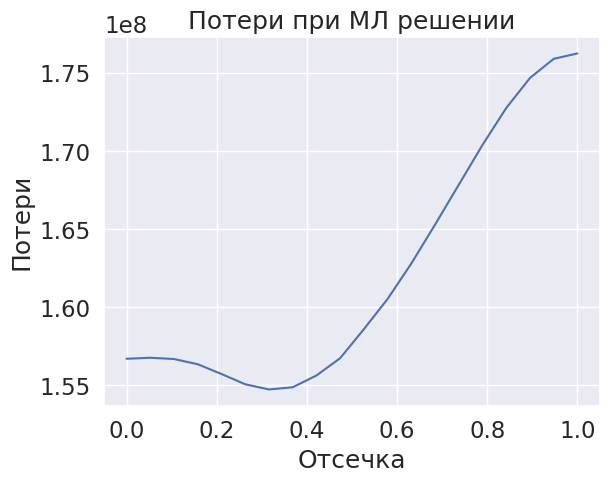

Уровень порога по бизнес метрике:  0.3157894736842105
Уровень порога по f1 метрике:  0.2260448850909679


In [ ]:
busines_tr = business_threshold_calibrate(y_test, preds_logreg,
                                          thresholds_logreg[ix],
                                          RUBL_TEST,
                                          RUBL_EARLY_TREATMENT,
                                          RUBL_LATE_TREATMENT)

print('Уровень порога по бизнес метрике: ', busines_tr)
print('Уровень порога по f1 метрике: ', thresholds_logreg[ix])

По f1 метрике наилучшую модель мы получаем при пороге 0.226. По метрике бизнеса наилучшую модель мы получаем при пороге 0.316. Разрыв между метриками классификации и бизнес-эффективностью – распространенная ситуация. Модель с чуть более скромными классификационными метриками часто оказывается выгоднее, потому что она лучше учитывает стоимость ошибок и ограничения бизнес-процессов.